In [2]:
!python -m pip install --upgrade pip
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import tensorboard as tb
from tensorboard.plugins import projector
import os
import io

In [6]:
df = pd.read_csv('../data/train.csv')

C:\Users\ai_rl\AppData\Local\Temp\ipykernel_9636\4052693034.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, ax=axes[i], palette='viridis', order = df[col].value_counts().index)
C:\Users\ai_rl\AppData\Local\Temp\ipykernel_9636\4052693034.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, ax=axes[i], palette='viridis', order = df[col].value_counts().index)
C:\Users\ai_rl\AppData\Local\Temp\ipykernel_9636\4052693034.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, a

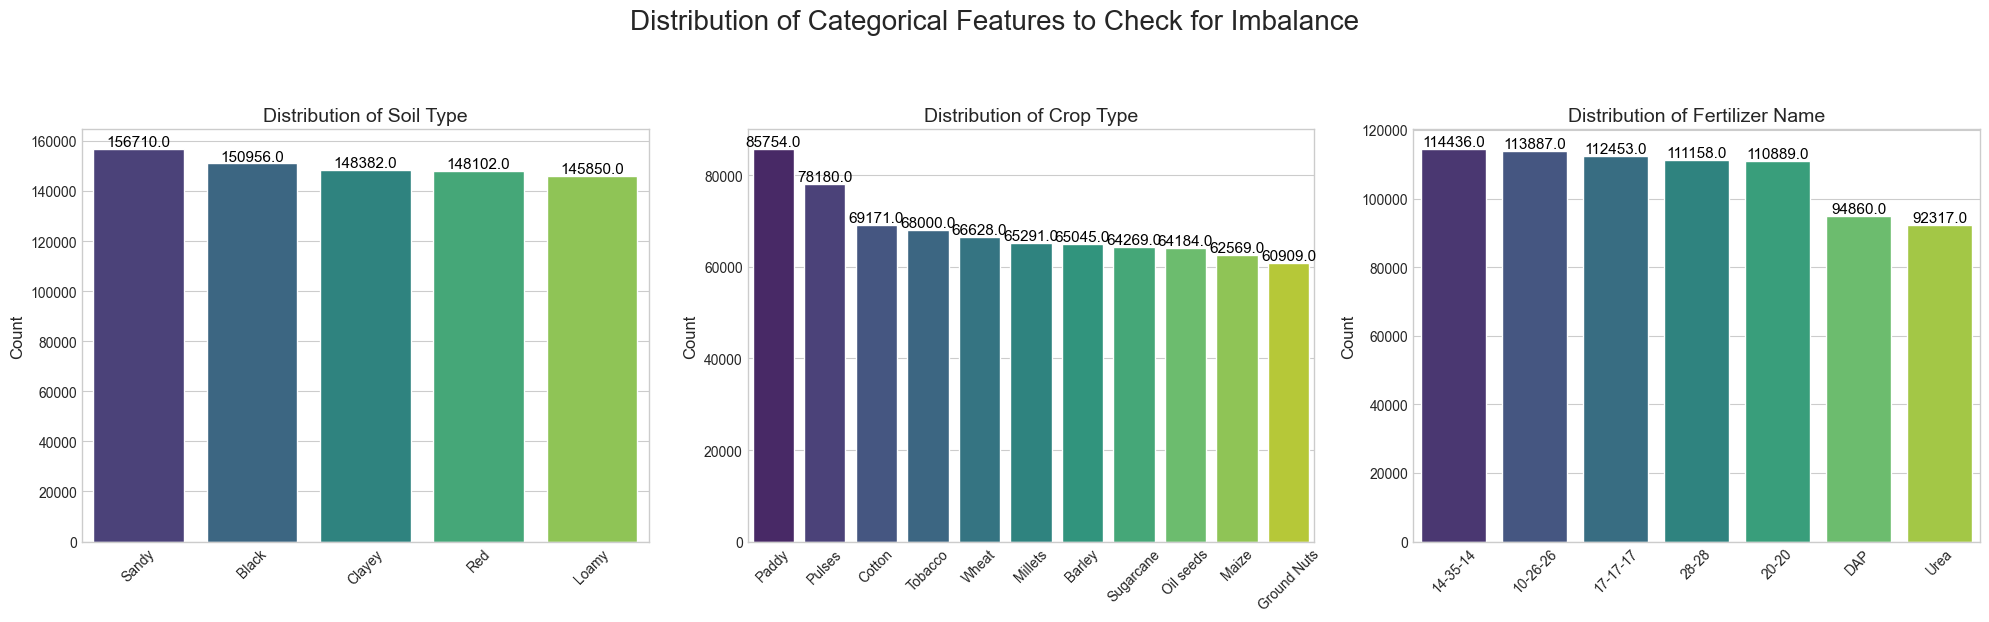

--- Value Counts for each Categorical Column ---

--- Soil Type ---
Soil Type
Sandy     156710
Black     150956
Clayey    148382
Red       148102
Loamy     145850
Name: count, dtype: int64
-----------------

--- Crop Type ---
Crop Type
Paddy          85754
Pulses         78180
Cotton         69171
Tobacco        68000
Wheat          66628
Millets        65291
Barley         65045
Sugarcane      64269
Oil seeds      64184
Maize          62569
Ground Nuts    60909
Name: count, dtype: int64
-----------------

--- Fertilizer Name ---
Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64
-----------------------


In [7]:
# Set a visually appealing style for the plots
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')


# --- Visualization ---

# Define the categorical columns we want to inspect
categorical_cols = ['Soil Type', 'Crop Type', 'Fertilizer Name']

# Create a figure to hold the subplots
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(20, 6))
fig.suptitle('Distribution of Categorical Features to Check for Imbalance', fontsize=20, y=1.03)

# Loop through each categorical column and create a count plot
for i, col in enumerate(categorical_cols):
    ax = sns.countplot(x=col, data=df, ax=axes[i], palette='viridis', order = df[col].value_counts().index)
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45) # Rotate labels for better readability

    # Add counts on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black',
                    xytext=(0, 5), textcoords='offset points')

# Adjust layout to prevent labels from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Print value counts for text reference ---
print("--- Value Counts for each Categorical Column ---")
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())
    print("-" * (len(col) + 8))

In [19]:
# Define the log directory where TensorBoard files will be saved
log_dir = 'tensorboard_logs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

print(f"TensorBoard log directory created at: ./{log_dir}")


# --- 1. Prepare Feature Data (Vectors) ---
# Select the numerical features to visualize
numerical_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
feature_vectors = df[numerical_cols].values

# Convert to a TensorFlow Constant Tensor
feature_vectors_tensor = tf.constant(feature_vectors, dtype=tf.float32)


# --- 2. Prepare Metadata (Labels) ---
# Create the metadata file (metadata.tsv). This is a tab-separated file.
# The first line should be the header for our labels.
# We will include all categorical data as metadata.
metadata_cols = ['Fertilizer Name', 'Crop Type', 'Soil Type']
metadata_path = os.path.join(log_dir, 'metadata.tsv')

df[metadata_cols].to_csv(metadata_path, sep='\t', index=False)
print(f"Metadata file saved to: {metadata_path}")


# --- 3. Create and Save the TensorFlow Checkpoint ---
# This is where the feature vectors are stored for TensorBoard to read.
checkpoint_path = os.path.join(log_dir, 'features.ckpt')

# Create a TensorFlow variable with our feature data
checkpoint_variable = tf.Variable(feature_vectors_tensor, name='features')

# Create a checkpoint and save the variable
saver = tf.train.Checkpoint(embedding=checkpoint_variable)
saver.save(checkpoint_path)
print(f"Checkpoint file saved to: {checkpoint_path}")


# --- 4. Configure the TensorBoard Projector ---
# This tells TensorBoard where to find the vectors and their corresponding labels.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

# The tensor_name should match the name of the variable in the checkpoint
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv' # Relative path from log_dir

projector.visualize_embeddings(log_dir, config)
print("TensorBoard Projector configuration complete.")
print("\n--- Next Steps ---")
print("Open a terminal or command prompt and run the following command:")
print(f"tensorboard --logdir {log_dir}")
print("Then, open the provided URL in your browser and navigate to the 'PROJECTOR' tab.")

TensorBoard log directory created at: ./tensorboard_logs
Metadata file saved to: tensorboard_logs\metadata.tsv
Checkpoint file saved to: tensorboard_logs\features.ckpt
TensorBoard Projector configuration complete.

--- Next Steps ---
Open a terminal or command prompt and run the following command:
tensorboard --logdir tensorboard_logs
Then, open the provided URL in your browser and navigate to the 'PROJECTOR' tab.
